Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


# Contents
- ## [Implementation](#mplementation)
 - ### [List of Files](#list-of-files)
 - ### [Utility to call gc](#gc)
 - ### [Selection of Columns](#select-columns)
 - ### [Function to compare the three selections of columns for a given dataset](#compare-fn)
 - ### [Load the datasets](#load-dataset)
 - ### [Select the datasets](#dataset-selection)
 - ### [Run all combinations of data](#dataset-selection)
- ## [Results](#results)
 - ### [Print the raw results](#raw-results)
 - ### [Sort by the improvement when using Fourier transforms over baseline](#sorted-fourier)
 - ### [Measure improvement when only webp files are used](#webp-only)
 - ### [Measure improvement when webp files are not present](#no-webp)
 - ### [Measure improvement for balanced datasets](#balanced-dataset)
 - ### [Measure the improvement when all files are used](#full-dataset)
 - ### [Focus on items where the base metrics performed well](#focus-greater-90)
 - ### [Correlation of data set and performance]("corr-heatmap")
 - ### [Average out all the metrics](#mean-fscores)
 


## Implementation <a class="anchor" id="implementation">
    
[top](#Contents)

In [157]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

from functools import lru_cache

import gc

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import glob

import tqdm
from multiprocessing.pool import ThreadPool, Pool

plt.rcParams["figure.figsize"] = (20,20)

### List of files <a class="anchor" id="list-of-files">

[top](#Contents)

In [158]:
!ls

Iteration_2.1_EXT2_RF_CV5_compare_base32_logistic_regression.ipynb
expanded.plaintext.base32.csv.gz
expanded.pyencrypted_v1.b32.csv.gz
expanded.pyencrypted_v1.csv.gz
expanded.pyencrypted_v2.base32.csv.gz
expanded.pyencrypted_v2.csv.gz
iteration_2.1_compare_base32_alternate_encryption_scheme.ipynb
iteration_2.1_compare_base32_logistic_regression.ipynb
plaintext.base32.combined.csv.gz
plaintext.combined.csv.gz
plaintext.expanded.csv.gz


### Utility to call GC <a class="anchor" id="gc">
    
[top](#Contents)

In [159]:
def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)

### Selection of columns <a class="anchor" id="select-columns">
    
This function is used to select the columns.
There are three different configurations:
    
    1. Baseline - statistics like autocorrelation, shannon entropy, chi-square etc. are used
    
    2. Advanced - More statistics like moments, Tsallis and Renyi entropy, higher moments etc.
    
    3. Fourier - Some statistics of the Fourier Power Spectrum distribution
    
[top](#Contents)

In [160]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))
    
    return {\
        "baseline": baseline_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier-only": fourier_columns_only,\
        "baseline-and-fourier": baseline_and_fourier,\
        "advanced-and-fourier": advanced_and_fourier,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
    }

### Function to compare the three selections of columns for a given dataset <a class="anchor" id="compare-fn">
    
For the three different sets of measurements described above, compare all the three sets for their f1 score
    
[top](#Contents)

In [161]:
USE_ASYNC = False
N_SPLITS=5

def get_kfold_f1_score(name, collist, X, y):
    skf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    X = X[collist].to_numpy()
    y = y.to_numpy()
    call_gc()
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        rfc = RandomForestClassifier(n_jobs=10, random_state=42)
        estimators = [\
                      ('std,', MinMaxScaler()), \
                      ('RandomForestClassifier', rfc)]
        pipeline = Pipeline(estimators)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    return name, \
            float(np.mean(f1_scores)),\
            float(np.mean(accuracy_scores)),\
            float(np.mean(precision_scores)),\
            float(np.mean(recall_scores)),

def compare_feature_selections_async(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    pool = Pool(3)
    async_results = list()
    for name, collist in columns_dict.items():
        result = pool.apply_async(\
                                  get_kfold_f1_score, \
                                  (name, collist, X, y))
    for result in async_results:
        name, f1 = result.get(timeout=None)
        ret[name] = f1
    return ret

def compare_feature_selections_sync(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    for name, collist in columns_dict.items():
        name, f1, accuracy, precision, recall = \
            get_kfold_f1_score(name, collist, X, y)
        ret[f"{name}-f1_score"] = f1
        ret[f"{name}-accuracy_score"] = accuracy
        ret[f"{name}-precision_score"] = precision
        ret[f"{name}-recall_score"] = recall
    return ret

def compare_feature_selections(X, y):
    if USE_ASYNC:
        return compare_feature_selections_async(X, y)
    else:
        return compare_feature_selections_sync(X, y)

def compare_feature_selections_wrapper(data):
    X = data[[c for c in data.columns if "is_encrypted" != c]]
    y = data["is_encrypted"]
    return compare_feature_selections(X, y)


### Load the datasets <a class="anchor" id="load-dataset">

We don't want to load the datasets again and again, so we load them once.
The LRU cache ensures that the next time this is called, we don't load the datasets again.
    
[top](#Contents)

In [162]:
@lru_cache
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("*.csv.gz"):
        df = pd.read_csv(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

### Select the datasets <a class="anchor" id="dataset-selection">

Select the dataset, combine it, shuffle it and return
    
We used several schemes:
* Plaintext
  - The base plaintext dataset of around 50k files
  - Expanded dataset, where all files that were less than 1500 bytes were expanded by repeating the file
  - Base32 encoding of
   - original plaintext
   - expanded plaintext
* Encryption : We used two schemes for encruption
  - v1 : AES 256 encryption of the full file, again two varieties were used
    - Plain encryption
    - Encryption followed by base32 encoding
  - v2 : AES encryption of the file, the first and the last 128 bytes are not encrypted. Of the remaining file, every alternate 16 bytes are encrypted.
    - Plain encryption
    - encryption followed by base32 encoding
    
We select combinations of the above datasets
    
Furthermore, we add further combinations by including and excluding webp files, and including and excluding non-webp files.
    
[top](#Contents)

In [163]:
def get_dataset(\
               exclude_plaintext_nonbase32=False,
               exclude_plaintext_base32=False,
               exclude_encrypted_v1=False,
               exclude_encrypted_v2=False,
               exclude_encrypted_base32=False,
               exclude_encrypted_nonbase32=False,
               exclude_webp=False,
               exclude_nonwebp=False):
    description = {k:v for k,v in locals().items() \
                   if "exclude" in k}
    
    files = glob.glob("*.csv.gz")
    
    
    if exclude_plaintext_nonbase32:
        files = [f for f in files if \
                     "plaintext" not in f \
                     or "_base32" in f \
                     or "_b32" in f]
    if exclude_plaintext_base32:
        files = [f for f in files if\
                    "plaintext" not in f or \
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_v1:
        files = [f for f in files if\
                    "_v1" not in f or "encr" not in f]
    if exclude_encrypted_v2:
        files = [f for f in files if \
                    "_v2" not in f or "encr" not in f]
    if exclude_encrypted_base32:
        files = [ f for f in files if\
                    "encr" not in f or\
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_nonbase32:
        files = [f for f in files if \
                    "encr" not in f or \
                    "base32" in f or "b32" in f]
        
        
    encrypted_count = len([f for f in files if "encr" in f])
    non_encrypted_count = len([f for f in files if "encr" not in f])
    
    if 0 == encrypted_count or 0 == non_encrypted_count or 0 == len(files):
        return description, None, -1, -1
    
    all_dfs = list()
    all_loaded_datasets = load_datasets_once()
    for filename in files:
        all_dfs.append(all_loaded_datasets[filename])
    
    combined_df = pd.concat(all_dfs)
    
    if exclude_webp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] != ".webp"]
    if exclude_nonwebp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] == ".webp"]
        
    if len(combined_df) == 0:
        return description, None, -1, -1
    
        
    encrypt_count = len(combined_df[combined_df["is_encrypted"] == 1])
    nonencrypted_count = len(combined_df[combined_df["is_encrypted"] == 0])

    
    if 0 == len(combined_df) or 0 == encrypt_count or 0 == nonencrypted_count:
        return description, None, -1, -1
    
    return description, combined_df, encrypt_count, nonencrypted_count

### Run all combinations of data <a class="anchor" id="dataset-selection">

For all combinations of the datasets, compare the three classes (basic, advanced, and Fourier)
    
[top](#Contents)

In [164]:
all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

     
for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0]}
for result in all_results:
    for k, v in result.items():
        df_dict[k].append(v)

df = pd.DataFrame(df_dict)
df["best_f1_score"] = \
    df[[c for c in df.columns if "f1_score" in c]].max(axis=1)

df["improvement_in_advanced"] = \
    df["advanced-f1_score"] - df["baseline-f1_score"]
df["improvement_in_fourier"] = \
    df["fourier-f1_score"] - df["baseline-f1_score"]
df = df.sort_values(by="improvement_in_fourier", ascending=False)                        

100%|█████████████████████████████████████████████████| 256/256 [8:22:30<00:00, 117.78s/it]


## Results <a class="anchor" id="results">
    
In this section, we present the results
    
[top](#Contents)

### Print the raw results <a class="anchor" id="raw-results">
    
[top](#Contents)

In [165]:
df

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,...,fourier-f1_score,fourier-accuracy_score,fourier-precision_score,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier
37,False,False,False,True,True,False,False,True,0.709224,0.900945,...,0.891575,0.958868,0.942949,0.845534,31625,126500,0.25,0.891575,0.164691,0.182351
10,False,True,False,True,True,False,False,True,0.713563,0.837344,...,0.890656,0.930804,0.940957,0.845470,31625,63250,0.50,0.890656,0.162043,0.177093
43,False,False,False,True,False,False,False,True,0.673574,0.817744,...,0.841367,0.902282,0.916777,0.777439,63250,126500,0.50,0.841367,0.156149,0.167793
40,False,False,False,True,False,True,False,True,0.633165,0.879361,...,0.786096,0.923118,0.886116,0.706372,31625,126500,0.25,0.786096,0.147666,0.152931
31,False,False,True,False,False,True,False,True,0.570486,0.868041,...,0.699117,0.902552,0.913894,0.566103,31625,126500,0.25,0.699117,0.096275,0.128631
34,False,False,True,False,False,False,False,True,0.634183,0.806340,...,0.745413,0.858493,0.931044,0.621518,63250,126500,0.50,0.745413,0.093662,0.111230
32,False,False,True,False,False,True,False,False,0.725133,0.907331,...,0.826103,0.938268,0.946061,0.733145,80853,323412,0.25,0.826103,0.060591,0.100970
35,False,False,True,False,False,False,False,False,0.776119,0.870248,...,0.873108,0.922578,0.962240,0.799092,161706,323412,0.50,0.873108,0.057846,0.096989
28,False,False,True,False,True,False,False,True,0.696362,0.900009,...,0.791014,0.928108,0.944758,0.680316,31625,126500,0.25,0.791014,0.089220,0.094652
1,False,True,True,False,True,False,False,True,0.694236,0.832306,...,0.788553,0.878788,0.942020,0.678103,31625,63250,0.50,0.788645,0.089922,0.094317


In [166]:
df.to_csv("../comparison.csv")

In [167]:
df = df.sort_values(by="improvement_in_fourier", ascending=False)

### Sort by the improvement when using Fourier transforms over baseline <a class="anchor" id="sorted-fourier">

We also take a few other things:
* Room for improvement (1 - baseline score)
* How much of the room for improvement was filled by fourier transforms (percentage)
* Difference between F1 score with advanced and fourier
        
[top](#Contents)

In [168]:
df["improvement_in_advanced"] = \
    df["advanced-f1_score"] - df["baseline-f1_score"]
df["room_for_improvement"] = \
    1.0 - df["baseline-f1_score"]
df["fourier_minus_advanced"] = \
    df["fourier-f1_score"] - df["advanced-f1_score"]
df["percentage_of_room_filled"] = \
    df["improvement_in_fourier"] * 100.0 / df["room_for_improvement"]
#df.sort_values(by="fourier_minus_advanced", ascending=False)
df

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,...,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
37,False,False,False,True,True,False,False,True,0.709224,0.900945,...,0.845534,31625,126500,0.25,0.891575,0.164691,0.182351,0.290776,0.017660,62.711760
10,False,True,False,True,True,False,False,True,0.713563,0.837344,...,0.845470,31625,63250,0.50,0.890656,0.162043,0.177093,0.286437,0.015050,61.826282
43,False,False,False,True,False,False,False,True,0.673574,0.817744,...,0.777439,63250,126500,0.50,0.841367,0.156149,0.167793,0.326426,0.011644,51.403117
40,False,False,False,True,False,True,False,True,0.633165,0.879361,...,0.706372,31625,126500,0.25,0.786096,0.147666,0.152931,0.366835,0.005265,41.689239
31,False,False,True,False,False,True,False,True,0.570486,0.868041,...,0.566103,31625,126500,0.25,0.699117,0.096275,0.128631,0.429514,0.032356,29.948069
34,False,False,True,False,False,False,False,True,0.634183,0.806340,...,0.621518,63250,126500,0.50,0.745413,0.093662,0.111230,0.365817,0.017569,30.405971
32,False,False,True,False,False,True,False,False,0.725133,0.907331,...,0.733145,80853,323412,0.25,0.826103,0.060591,0.100970,0.274867,0.040378,36.734026
35,False,False,True,False,False,False,False,False,0.776119,0.870248,...,0.799092,161706,323412,0.50,0.873108,0.057846,0.096989,0.223881,0.039142,43.321542
28,False,False,True,False,True,False,False,True,0.696362,0.900009,...,0.680316,31625,126500,0.25,0.791014,0.089220,0.094652,0.303638,0.005432,31.172752
1,False,True,True,False,True,False,False,True,0.694236,0.832306,...,0.678103,31625,63250,0.50,0.788645,0.089922,0.094317,0.305764,0.004395,30.846467


### Measure improvement when only webp files are used <a class="anchor" id="webp-only">

We want to measure this alone because in the literature, poor performance in webp files has been mentioned
    
[top](#Contents)

In [169]:
df[(df["exclude_webp"] == False) & \
   (df["exclude_nonwebp"] == True)]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,...,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
37,False,False,False,True,True,False,False,True,0.709224,0.900945,...,0.845534,31625,126500,0.25,0.891575,0.164691,0.182351,0.290776,0.017660,62.711760
10,False,True,False,True,True,False,False,True,0.713563,0.837344,...,0.845470,31625,63250,0.50,0.890656,0.162043,0.177093,0.286437,0.015050,61.826282
43,False,False,False,True,False,False,False,True,0.673574,0.817744,...,0.777439,63250,126500,0.50,0.841367,0.156149,0.167793,0.326426,0.011644,51.403117
40,False,False,False,True,False,True,False,True,0.633165,0.879361,...,0.706372,31625,126500,0.25,0.786096,0.147666,0.152931,0.366835,0.005265,41.689239
31,False,False,True,False,False,True,False,True,0.570486,0.868041,...,0.566103,31625,126500,0.25,0.699117,0.096275,0.128631,0.429514,0.032356,29.948069
34,False,False,True,False,False,False,False,True,0.634183,0.806340,...,0.621518,63250,126500,0.50,0.745413,0.093662,0.111230,0.365817,0.017569,30.405971
28,False,False,True,False,True,False,False,True,0.696362,0.900009,...,0.680316,31625,126500,0.25,0.791014,0.089220,0.094652,0.303638,0.005432,31.172752
1,False,True,True,False,True,False,False,True,0.694236,0.832306,...,0.678103,31625,63250,0.50,0.788645,0.089922,0.094317,0.305764,0.004395,30.846467
16,False,True,False,True,False,False,False,True,0.868291,0.878261,...,0.923336,63250,63250,1.00,0.946992,0.071319,0.078701,0.131709,0.007382,59.753892
49,False,False,False,False,False,True,False,True,0.782918,0.865486,...,0.811968,63250,126500,0.50,0.852286,0.054071,0.069367,0.217082,0.015296,31.954407


### Measure improvement when webp files are not present <a class="anchor" id="no-webp">
    
[top](#Contents)

In [170]:
df[(df["exclude_webp"] == True) & \
   (df["exclude_nonwebp"] == False)]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,...,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
30,False,False,True,False,False,True,True,False,0.840623,0.942061,...,0.895324,49228,196912,0.25,0.929793,0.045752,0.089170,0.159377,0.043418,55.948876
33,False,False,True,False,False,False,True,False,0.874084,0.922145,...,0.938907,98456,196912,0.50,0.959957,0.038388,0.085873,0.125916,0.047486,68.198654
0,False,True,True,False,True,False,True,False,0.906860,0.941111,...,0.983383,49228,98456,0.50,0.989766,0.030546,0.082906,0.093140,0.052360,89.012541
27,False,False,True,False,True,False,True,False,0.907049,0.964841,...,0.982652,49228,196912,0.25,0.989304,0.031068,0.082255,0.092951,0.051187,88.493021
48,False,False,False,False,False,True,True,False,0.925899,0.952686,...,0.952425,98456,196912,0.50,0.966806,0.020919,0.040907,0.074101,0.019988,55.204108
51,False,False,False,False,False,False,True,False,0.940204,0.942269,...,0.972551,196912,196912,1.00,0.980983,0.018607,0.040779,0.059796,0.022172,68.196693
6,False,True,True,False,False,False,True,False,0.954134,0.955376,...,0.991580,98456,98456,1.00,0.994849,0.014964,0.040715,0.045866,0.025751,88.769048
45,False,False,False,False,True,False,True,False,0.954663,0.970552,...,0.992789,98456,196912,0.50,0.995134,0.015561,0.040471,0.045337,0.024910,89.266011
18,False,True,False,False,True,False,True,False,0.954649,0.955813,...,0.992636,98456,98456,1.00,0.995087,0.015234,0.040438,0.045351,0.025204,89.167268
24,False,True,False,False,False,False,True,False,0.977496,0.970396,...,0.996455,196912,98456,2.00,0.997600,0.007778,0.020105,0.022504,0.012326,89.336378


### Measure improvement for balanced datasets <a class="anchor" id="balanced-dataset">

Most of our dataset selections are not balanced, and we didn't do anything to mitigate
unablanced datasets. This is because we are measuring the baseline and improvement on the
same dataset.
    
However, we will select those instances where the datasets were balanced to see if the
improvement is still significant in these instances.
    
[top](#Contents)

In [171]:
df[df["ratio_encrypt_nonencrypt"] == 1.0]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,...,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
16,False,True,False,True,False,False,False,True,0.868291,0.878261,...,0.923336,63250,63250,1.0,0.946992,0.071319,0.078701,0.131709,0.007382,59.753892
52,False,False,False,False,False,False,False,True,0.796839,0.811545,...,0.814514,126500,126500,1.0,0.862600,0.055450,0.065761,0.203161,0.010312,32.368912
19,False,True,False,False,True,False,False,True,0.810004,0.824490,...,0.818656,63250,63250,1.0,0.874417,0.058071,0.064413,0.189996,0.006342,33.902366
20,False,True,False,False,True,False,False,False,0.908785,0.911126,...,0.938116,161706,161706,1.0,0.952802,0.025140,0.044017,0.091215,0.018877,48.256429
53,False,False,False,False,False,False,False,False,0.896003,0.898914,...,0.928237,323412,323412,1.0,0.939706,0.025717,0.043703,0.103997,0.017986,42.023209
8,False,True,True,False,False,False,False,False,0.916562,0.920915,...,0.931004,161706,161706,1.0,0.959570,0.025906,0.043008,0.083438,0.017103,51.545381
51,False,False,False,False,False,False,True,False,0.940204,0.942269,...,0.972551,196912,196912,1.0,0.980983,0.018607,0.040779,0.059796,0.022172,68.196693
6,False,True,True,False,False,False,True,False,0.954134,0.955376,...,0.991580,98456,98456,1.0,0.994849,0.014964,0.040715,0.045866,0.025751,88.769048
7,False,True,True,False,False,False,False,True,0.862443,0.874585,...,0.839067,63250,63250,1.0,0.903055,0.038126,0.040612,0.137557,0.002486,29.523747
18,False,True,False,False,True,False,True,False,0.954649,0.955813,...,0.992636,98456,98456,1.0,0.995087,0.015234,0.040438,0.045351,0.025204,89.167268


### Measure the improvement when all files are used <a class="anchor" id="full-dataset">

In most of our dataset selections, we excluded some data points based on our criteria.

In this, we measure the improvement when we use all data points
    
[top](#Contents)

In [172]:
# Measure everything for the full dataset
df2 = df
for colname in df2.columns:
    if "exclude" in colname:
        df2 = df2[df2[colname] == False]
df2

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,...,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
53,False,False,False,False,False,False,False,False,0.896003,0.898914,...,0.928237,323412,323412,1.0,0.939706,0.025717,0.043703,0.103997,0.017986,42.023209


In [173]:
df2[[c for c in df2.columns if "baseline" in c or "fourier" in c or "advanced-only" in c]]

,baseline-f1_score,baseline-accuracy_score,baseline-precision_score,baseline-recall_score,advanced-only-f1_score,advanced-only-accuracy_score,advanced-only-precision_score,advanced-only-recall_score,fourier-only-f1_score,fourier-only-accuracy_score,...,advanced-and-fourier-f1_score,advanced-and-fourier-accuracy_score,advanced-and-fourier-precision_score,advanced-and-fourier-recall_score,fourier-f1_score,fourier-accuracy_score,fourier-precision_score,fourier-recall_score,improvement_in_fourier,fourier_minus_advanced
53,0.896003,0.898914,0.922575,0.87092,0.904735,0.907476,0.932356,0.878703,0.797437,0.765066,...,0.933094,0.934021,0.946384,0.920173,0.939706,0.940441,0.951462,0.928237,0.043703,0.017986


In [174]:
df.to_csv("../comparison_logistic_regression_final.csv")

### Focus on items where the base metrics performed well <a class="anchor" id="focus-greater-90">

We see that in all cases, plaintext non-base 32 only is selected. Also we
see that for encrypted, only base32 is selected and non-base32 excluded.
    
Fundamentally, what this is measuring is when the plaintext has all files
but all encrypted content is base-32 encoded.

Typically, base-32 encoding will lead to a reduction of entropy, in many cases
much less than the original text, and this is what it is measuring.
    
[top](#Contents)

In [175]:
df[df["baseline-f1_score"] > 0.9]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,...,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
0,False,True,True,False,True,False,True,False,0.906860,0.941111,...,0.983383,49228,98456,0.50,0.989766,0.030546,0.082906,0.093140,0.052360,89.012541
27,False,False,True,False,True,False,True,False,0.907049,0.964841,...,0.982652,49228,196912,0.25,0.989304,0.031068,0.082255,0.092951,0.051187,88.493021
11,False,True,False,True,True,False,False,False,0.903524,0.937277,...,0.951740,80853,161706,0.50,0.957673,0.046735,0.054149,0.096476,0.007414,56.126687
38,False,False,False,True,True,False,False,False,0.904075,0.962520,...,0.951121,80853,323412,0.25,0.956946,0.045109,0.052871,0.095925,0.007762,55.116733
20,False,True,False,False,True,False,False,False,0.908785,0.911126,...,0.938116,161706,161706,1.00,0.952802,0.025140,0.044017,0.091215,0.018877,48.256429
8,False,True,True,False,False,False,False,False,0.916562,0.920915,...,0.931004,161706,161706,1.00,0.959570,0.025906,0.043008,0.083438,0.017103,51.545381
47,False,False,False,False,True,False,False,False,0.909485,0.941198,...,0.937714,161706,323412,0.50,0.952315,0.023809,0.042831,0.090515,0.019022,47.318871
48,False,False,False,False,False,True,True,False,0.925899,0.952686,...,0.952425,98456,196912,0.50,0.966806,0.020919,0.040907,0.074101,0.019988,55.204108
51,False,False,False,False,False,False,True,False,0.940204,0.942269,...,0.972551,196912,196912,1.00,0.980983,0.018607,0.040779,0.059796,0.022172,68.196693
6,False,True,True,False,False,False,True,False,0.954134,0.955376,...,0.991580,98456,98456,1.00,0.994849,0.014964,0.040715,0.045866,0.025751,88.769048


### Correlation of data set and performance <a class="anchor" id="corr-heatmap">
    
This gives more idea on how data-set selection affects performance.
    
[top](#Contents)

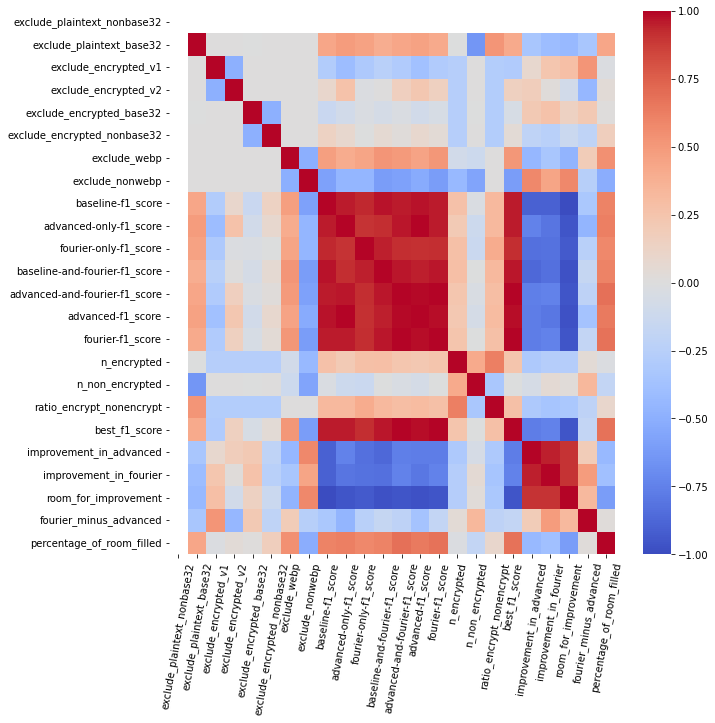

In [176]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
df2 = df[[c for c in df.columns if \
          "precision" not in c and \
          "accuracy" not in c and \
          "recall" not in c]]
sns.heatmap(df2.astype(float).corr(), cmap='coolwarm')
# print(df[df["baseline-f1_score"] > 0.9].astype(float))
_ = plt.xticks(rotation=80) 

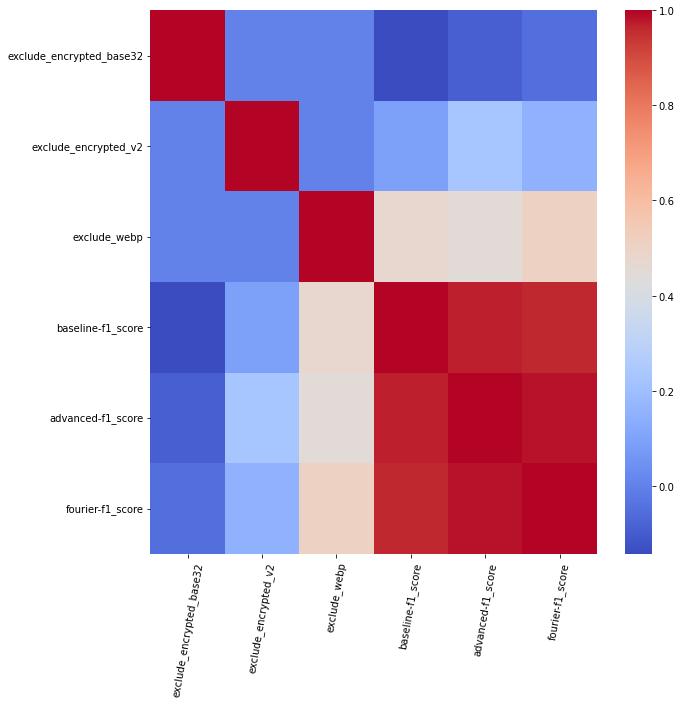

In [177]:
df1 = df[["exclude_encrypted_base32", \
          "exclude_encrypted_v2", \
          "exclude_webp", \
          "baseline-f1_score", \
          "advanced-f1_score", \
          "fourier-f1_score"]]
sns.heatmap(df1.astype(float).corr(), cmap='coolwarm')
_ = plt.xticks(rotation=80) 

### Average out all the metrics <a class="anchor" id="mean-fscores">

To conclude we report the average of the f1-scores and the improvements with all datasets
    
[top](#Contents)

In [178]:
df[[c for c in df.columns if ("score" in c or "improvement" in c) and "room" not in c]].mean()

baseline-f1_score                       0.880013
baseline-accuracy_score                 0.930481
baseline-precision_score                0.939605
baseline-recall_score                   0.835550
advanced-only-f1_score                  0.907818
advanced-only-accuracy_score            0.944956
advanced-only-precision_score           0.955664
advanced-only-recall_score              0.869634
fourier-only-f1_score                   0.734340
fourier-only-accuracy_score             0.878111
fourier-only-precision_score            0.874365
fourier-only-recall_score               0.714305
baseline-and-fourier-f1_score           0.888630
baseline-and-fourier-accuracy_score     0.939137
baseline-and-fourier-precision_score    0.947858
baseline-and-fourier-recall_score       0.853430
advanced-and-fourier-f1_score           0.930944
advanced-and-fourier-accuracy_score     0.959103
advanced-and-fourier-precision_score    0.967481
advanced-and-fourier-recall_score       0.901837
advanced-f1_score   

In [179]:
df[[c for c in df.columns if \
    ("-and-" in c or \
     "only" in c or \
     "score" in c or \
     "improvement" in c) and "room" not in c]].describe().T

,count,mean,std,min,25%,50%,75%,max
baseline-f1_score,54.0,0.880013,0.114956,0.570486,0.813608,0.906954,0.989643,1.000000
baseline-accuracy_score,54.0,0.930481,0.057713,0.806340,0.886180,0.941154,0.990462,1.000000
baseline-precision_score,54.0,0.939605,0.054548,0.807829,0.904797,0.947519,0.991798,1.000000
baseline-recall_score,54.0,0.835550,0.155797,0.438166,0.741426,0.872262,0.987583,1.000000
advanced-only-f1_score,54.0,0.907818,0.084977,0.636478,0.862454,0.926994,0.982531,1.000000
advanced-only-accuracy_score,54.0,0.944956,0.043531,0.840690,0.914900,0.947379,0.989676,1.000000
advanced-only-precision_score,54.0,0.955664,0.036919,0.863823,0.931267,0.957966,0.989792,1.000000
advanced-only-recall_score,54.0,0.869634,0.120758,0.503874,0.804435,0.895691,0.977320,1.000000
fourier-only-f1_score,54.0,0.734340,0.298946,0.018151,0.675207,0.834657,0.972472,1.000000
fourier-only-accuracy_score,54.0,0.878111,0.098882,0.677692,0.808489,0.875038,0.978847,1.000000


In [180]:
df1 = df[[c for c in df.columns if \
          ("score" in c or "improvement" in c) \
          and "room" not in c]]
columns = ["baseline-f1_score"]
columns += [c for c in df1.columns if "only" in c]
columns += [c for c in df1.columns if "-and-" in c]
columns += [c for c in df1.columns if "only" not in c \
            and "-and-" not in c and "baseline-f1_score" != c]
df1[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
baseline-f1_score,54.0,0.880013,0.114956,0.570486,0.813608,0.906954,0.989643,1.000000
advanced-only-f1_score,54.0,0.907818,0.084977,0.636478,0.862454,0.926994,0.982531,1.000000
advanced-only-accuracy_score,54.0,0.944956,0.043531,0.840690,0.914900,0.947379,0.989676,1.000000
advanced-only-precision_score,54.0,0.955664,0.036919,0.863823,0.931267,0.957966,0.989792,1.000000
advanced-only-recall_score,54.0,0.869634,0.120758,0.503874,0.804435,0.895691,0.977320,1.000000
fourier-only-f1_score,54.0,0.734340,0.298946,0.018151,0.675207,0.834657,0.972472,1.000000
fourier-only-accuracy_score,54.0,0.878111,0.098882,0.677692,0.808489,0.875038,0.978847,1.000000
fourier-only-precision_score,54.0,0.874365,0.125534,0.564108,0.764098,0.920985,0.983257,1.000000
fourier-only-recall_score,54.0,0.714305,0.337490,0.009233,0.516844,0.880595,0.982931,1.000000
baseline-and-fourier-f1_score,54.0,0.888630,0.131571,0.457295,0.842376,0.938457,0.993584,1.000000
